- I tried to use Tensorflow, but 
    - I didn't understand how to access what was happening under the hood.  I like to run my fingers through the numbers, and I couldn't see them, so I think I had problems but couldn't find them, and
    - I think Tensors make the operation too complicated for some of my imbalanced data techniques.
- This attempt is really basic, an adaptation of the Keras example for structured data, "Imbalanced Data: Credit Card Fraud Detection" example at 
https://keras.io/examples/structured_data/imbalanced_classification/

In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))
#import tensorflow_datasets as tfds

from keras import layers
import keras.backend as K

from keras.utils.generic_utils import get_custom_objects

from keras.layers import IntegerLookup
from keras.layers import Normalization
from keras.layers import StringLookup

from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import seaborn as sns
print ('Seaborn version: {}'.format(sns.__version__))

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier

!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]
NumPy version: 1.24.0
SciPy version:  1.9.3
TensorFlow version:  2.10.0
Keras version:  2.10.0
Pandas version:  1.5.2
Seaborn version: 0.12.1
SciKit-Learn version: 1.2.0
Imbalanced-Learn version: 0.10.0
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Finished Installing Packages


## Get Data

In [3]:
def Get_Data():
    print ('Get_Data()')
    data = pd.read_csv(
        '../../Big_Files/CRSS_Imputed_All_12_22_22.csv',
        low_memory=False
    )
    print ('data.shape: ', data.shape)
    
    print ('End Get_Data()')
    print ()
    return data

def Test_Get_Data():
    data = Get_Data()
    display (data.head())
    
Test_Get_Data()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()



,CASENUM,INT_HWY,MONTH,PEDS,PERMVIT,REL_ROAD,SCH_BUS,URBANICITY,VE_TOTAL,DAY_WEEK,...,RELJCT2,REST_USE,AIR_BAG,TYP_INT,VSPD_LIM,VPROFILE,ALC_RES,ALC_STATUS,VEH_ALCH,VTRAFWAY
0,201701219525,0,0,0,1,1,0,1,2,1,...,1,1,1,1,2,1,0,1,1,0
1,201800450781,0,0,0,0,0,0,2,1,1,...,1,1,1,1,7,1,0,1,1,0
2,201901811861,0,2,0,0,2,0,1,2,1,...,1,1,1,1,7,1,0,1,1,0
3,201701360851,0,1,0,1,1,0,1,2,0,...,1,1,1,1,2,1,0,1,1,0
4,201901343065,0,0,0,1,1,0,1,2,0,...,1,1,1,1,2,1,0,1,1,0


# Remove_Pedestrian_Crashes

In [4]:
def Remove_Pedestrian_Crashes(data):
    display(data.PEDS.value_counts())
    n = len(data[data.PEDS>0])
    print ('Removing %d crashes that involve a pedestrian.' % n)
    data = data[data.PEDS==0]
    return data

## Engineer Features

In [5]:
def Feature_Engineering_Cross_Two(data):
    print ('Feature_Engineering_Cross_Two')
    Pairs = [
        ['AGE', 'SEX', 'AGE_x_SEX'],
        ['AGE', 'SCH_BUS', 'AGE_x_SCH_BUS']
    ]
    for P in Pairs:
        data[P[2]] = data[P[0]].map(str) + '_x_' + data[P[1]].map(str)
    
    print ()
    return data
        

## Thin Features

In [6]:
def Thin_Features(data):
    print ('Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
        'LGT_COND',
        'MONTH',
#        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
        'RELJCT2',
        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
        'VE_FORMS',
        'VE_TOTAL',
        'WEATHER',
        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
        'BODY_TYP',
        'BUS_USE',
        'EMER_USE',
        'MAKE',
#        'MOD_YEAR',
        'MODEL',
        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
        'LOCATION',
        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
        'VEH_AGE',
        'AGE_x_SEX',
        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Thin_Features():
    data = Get_Data()
    data = Thin_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_Features()
data.shape:  (619027, 39)
End Thin_Features()



2    395203
3    111949
0     47951
1     42134
4     21790
Name: AGE, dtype: int64

1    221301
5    153085
3     92952
2     59376
0     46961
4     45352
Name: BODY_TYP, dtype: int64

1    616201
2      2699
0       127
Name: BUS_USE, dtype: int64

1    465260
0    153767
Name: DAY_WEEK, dtype: int64

1    617091
0      1186
2       750
Name: EMER_USE, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

0    555566
1     63461
Name: INT_HWY, dtype: int64

3    445496
1    108465
0     50350
2     14716
Name: LGT_COND, dtype: int64

8    135069
0    121558
1     86857
6     81273
2     76578
4     71217
7     24997
3     12328
5      9150
Name: MAKE, dtype: int64

1    145569
4    136958
3    122451
2    112129
0    101920
Name: MODEL, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

3    348269
1    147867
5     62203
6     51666
2      6974
0      1565
4       483
Name: NUMOCCS, dtype: int64

2    348822
1    200622
0     69583
Name: PERMVIT, dtype: int64

0    589234
1     29793
Name: PERNOTMVIT, dtype: int64

2    456292
1    162609
0       126
Name: PER_TYP, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

0    603745
1     15282
Name: PVH_INVL, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

0    437984
8    161319
1     19460
9       264
Name: RELJCT1, dtype: int64

1    251423
0    168063
3    146673
2     52868
Name: RELJCT2, dtype: int64

1    549305
0     60920
2      8802
Name: REL_ROAD, dtype: int64

0    615928
1      3099
Name: SCH_BUS, dtype: int64

1    345482
0    273545
Name: SEX, dtype: int64

1    343683
2    204623
0     66083
3      4638
Name: TYP_INT, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    555113
0     48321
2     15593
Name: VALIGN, dtype: int64

0.0    199282
1.0    155216
2.0    132304
3.0     90266
4.0     41959
Name: VEH_AGE, dtype: int64

2    423804
1    107796
3     65694
4     21733
Name: VE_FORMS, dtype: int64

2    431474
1     95724
3     68682
4     23147
Name: VE_TOTAL, dtype: int64

1    528304
2     58774
0     31949
Name: VPROFILE, dtype: int64

2    170164
7    134614
5    102842
1     81817
4     60440
0     58578
3     10572
Name: VSPD_LIM, dtype: int64

1    508134
2     81404
3     27839
0      1650
Name: VSURCOND, dtype: int64

1    400366
2    144639
3     62181
0     11841
Name: VTRAFCON, dtype: int64

0    336731
3    122470
1     87216
4     43374
2     29236
Name: VTRAFWAY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

0    606925
1     11193
2       750
3       159
Name: WRK_ZONE, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

## Really Thin Features

In [7]:
def Really_Thin_Features(data):
    print ('Really_Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
#        'LOCATION',
#        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Thin_Features():
    data = Get_Data()
    data = Thin_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_Features()
data.shape:  (619027, 39)
End Thin_Features()



2    395203
3    111949
0     47951
1     42134
4     21790
Name: AGE, dtype: int64

1    221301
5    153085
3     92952
2     59376
0     46961
4     45352
Name: BODY_TYP, dtype: int64

1    616201
2      2699
0       127
Name: BUS_USE, dtype: int64

1    465260
0    153767
Name: DAY_WEEK, dtype: int64

1    617091
0      1186
2       750
Name: EMER_USE, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

0    555566
1     63461
Name: INT_HWY, dtype: int64

3    445496
1    108465
0     50350
2     14716
Name: LGT_COND, dtype: int64

8    135069
0    121558
1     86857
6     81273
2     76578
4     71217
7     24997
3     12328
5      9150
Name: MAKE, dtype: int64

1    145569
4    136958
3    122451
2    112129
0    101920
Name: MODEL, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

3    348269
1    147867
5     62203
6     51666
2      6974
0      1565
4       483
Name: NUMOCCS, dtype: int64

2    348822
1    200622
0     69583
Name: PERMVIT, dtype: int64

0    589234
1     29793
Name: PERNOTMVIT, dtype: int64

2    456292
1    162609
0       126
Name: PER_TYP, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

0    603745
1     15282
Name: PVH_INVL, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

0    437984
8    161319
1     19460
9       264
Name: RELJCT1, dtype: int64

1    251423
0    168063
3    146673
2     52868
Name: RELJCT2, dtype: int64

1    549305
0     60920
2      8802
Name: REL_ROAD, dtype: int64

0    615928
1      3099
Name: SCH_BUS, dtype: int64

1    345482
0    273545
Name: SEX, dtype: int64

1    343683
2    204623
0     66083
3      4638
Name: TYP_INT, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    555113
0     48321
2     15593
Name: VALIGN, dtype: int64

0.0    199282
1.0    155216
2.0    132304
3.0     90266
4.0     41959
Name: VEH_AGE, dtype: int64

2    423804
1    107796
3     65694
4     21733
Name: VE_FORMS, dtype: int64

2    431474
1     95724
3     68682
4     23147
Name: VE_TOTAL, dtype: int64

1    528304
2     58774
0     31949
Name: VPROFILE, dtype: int64

2    170164
7    134614
5    102842
1     81817
4     60440
0     58578
3     10572
Name: VSPD_LIM, dtype: int64

1    508134
2     81404
3     27839
0      1650
Name: VSURCOND, dtype: int64

1    400366
2    144639
3     62181
0     11841
Name: VTRAFCON, dtype: int64

0    336731
3    122470
1     87216
4     43374
2     29236
Name: VTRAFWAY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

0    606925
1     11193
2       750
3       159
Name: WRK_ZONE, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

## Get Dummies

In [8]:
def Get_Dummies(data, target):
    print ('Get_Dummies')
    data = data.astype('category')
    Target = data.pop(target)
    data_Dummies = pd.get_dummies(data, prefix = data.columns)
    data_Dummies = data_Dummies.join(Target)
#    for feature in data_Dummies:
#        print (feature)
    print ()

    return data_Dummies

def Test_Get_Dummies():
    print ('Test_Get_Dummies')
    A = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
        'C': [1, 2, 3]})
    C = Get_Dummies(A, 'C')
    display(C)
    print ()

Test_Get_Dummies()

Test_Get_Dummies
Get_Dummies



,A_a,A_b,B_a,B_b,B_c,C
0,1,0,0,1,0,1
1,0,1,1,0,0,2
2,1,0,0,0,1,3


## Test-Train Split
- We're using sklearn's train_test_split rather than Pandas's sample because the former has a 'stratify' option that will put the same proportion of HOSPITAL==1 into each set.

In [9]:
def Split_Data(data, target, test_size):
    print ('Split_Data()')
    X = data.drop(columns=[target])
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=42
    )
    
    a = y_train[y_train==1].shape[0]
    b = y_test[y_test==1].shape[0]
    print (
        x_train.shape, 
        y_train.shape, a, round((a/(a+b)*100),2), '%')
    print (
        x_test.shape, 
        y_test.shape, b, round((b/(a+b)*100),2), '%'
    )
    print ()
    
    return x_train, x_test, y_train, y_test

# Imbalanced Data Resampling

## Tomek Links

In [10]:
def Tomek_Links(X_train, y_train):
    print ('Tomek_Links()')
    N = X_train.shape[0]
    print ('X_train.shape before = ', X_train.shape)
    print ('y_train.shape before = ', y_train.shape)
    print ()
    X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
    n = X_train.shape[0]
    print ('X_train.shape after = ', X_train.shape)
    print ('y_train.shape after = ', y_train.shape)
    print ()
    print ('Removed %d samples, or %.2f%% of the set.' % (N-n, (N-n)/N*100))
    print ()
    
    return X_train, y_train

## Condensed Nearest Neighbor

In [11]:
def Condensed_Nearest_Neighbour(X_train, y_train):
    print ('Condensed_Nearest_Neighbour()')
    N = X_train.shape[0]
    print ('X_train.shape before = ', X_train.shape)
    print ('y_train.shape before = ', y_train.shape)
    print ()
    cnn = CondensedNearestNeighbour(n_neighbors=3)
    X_train, y_train = cnn.fit_resample(X_train, y_train)
    n = X_train.shape[0]
    print ('X_train.shape after = ', X_train.shape)
    print ('y_train.shape after = ', y_train.shape)
    print ()
    print ('Removed %d samples, or %.2f%% of the set.' % (N-n, (N-n)/N*100))
    print ()
    
    return X_train, y_train

# Custom Metrics
https://keras.io/api/metrics/

## Balanced Accuracy

In [12]:
def Balanced_Accuracy(y_true, y_pred):
    return K.mean(y_pred)

In [13]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [14]:
# https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
### Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
def custom_metric(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    P = K.sum(y_true)
    N = K.sum(1 - y_true)
    # Note that Tensorflow and Keras round using "banker's rounding,"
    # where halves round to the nearest even integer, so
    # round(0.5) = 0, but round (1.5) = 2
    Discrete_y_pred = K.round(y_pred)
    TRUE = K.equal(y_true, Discrete_y_pred)
    TRUE = tf.dtypes.cast(TRUE, tf.float64)
    FALSE = 1-TRUE
    Discrete_TP = Discrete_y_pred * TRUE
    TP = K.sum(Discrete_TP)
    FN = P - TP
    Discrete_TN = (1 - Discrete_y_pred) * TRUE
    TN = K.sum(Discrete_TN)
    FP = N - TN    

#    CM = confusion_matrix(y_true, y_pred)
#    print (CM)
#    P = CM[1][0] + CM[1][1]
#    N = CM[0][0] + CM[0][1]
#    TN = CM[0][0]
#    FP = CM[0][1]
#    FN = CM[1][0]
#    TP = CM[1][1]
#    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
    return P, N, TP, FN, TN, FP

def Test_Custom_Metric():
    y_true = [0.0,1.0,0.0,1.0]
    y_proba = [0.2, 0.49, 0.75, 0.9]
    y_pred = [round(x) for x in y_proba]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    print (y_true)
    print (y_pred)
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
Test_Custom_Metric()
    

tf.Tensor([0. 1. 0. 1.], shape=(4,), dtype=float64)
tf.Tensor([0 0 1 1], shape=(4,), dtype=int64)
TP =  tf.Tensor(1.0, shape=(), dtype=float64)  FN =  tf.Tensor(1.0, shape=(), dtype=float64)  FP =  tf.Tensor(1.0, shape=(), dtype=float64)  TN =  tf.Tensor(1.0, shape=(), dtype=float64)


In [16]:
def Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP+TN)/(TP + FN + FP + TN + K.epsilon())
    return metric

In [17]:
def Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FP + K.epsilon())
    return metric

In [18]:
def Recall_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FN + K.epsilon())
    return metric

In [19]:
def Balanced_Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = ( TN/(2*(TN + FP + K.epsilon())) + TP/(2*(FN + TP + K.epsilon())))
    return metric

In [20]:
def F1_Metric(y_true, y_pred):
    precision = Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

In [21]:
def Gmean_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    precision = TP/(TP + FP + K.epsilon())
    specificity = TN/(TN + FP + K.epsilon())
    metric = K.sqrt(precision * specificity)
    return metric

In [22]:
def Balanced_Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP * N)/(TP * N + FP * P + K.epsilon())
    return metric

In [23]:
def Balanced_F1_Metric(y_true, y_pred):
    precision = Balanced_Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

# Loss Functions

## Alpha Weighted Binary Crossentropy

In [24]:
def alpha_weighted_binary_crossentropy(y_true, y_pred):
    p = 5.94
    alpha = (p/(p+1))*1.0
    # Note:  y_true has to be the same type as y_pred to use in the "keras.backend.binary_crossentropy" function below.
    y_true = tf.cast(y_true, dtype=y_pred.dtype)


    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    product = tf.multiply(binary_crossentropy, weights)
#    print (product.numpy())
    loss = keras.backend.mean(product)
#    print (loss.numpy())
#    print (loss)
    return loss



In [25]:
def alpha_weighted_binary_crossentropy_with_parameters(p = 1.0):
    def alpha_weighted_binary_crossentropy(y_true, y_pred):
#        p = 5.94
        alpha = (p/(p+1))*1.0
        y_true = tf.cast(y_true, dtype=y_pred.dtype)

        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        product = tf.multiply(binary_crossentropy, weights)
        loss = keras.backend.mean(product)
        return loss
    return alpha_weighted_binary_crossentropy


## Focal Loss

In [26]:
def focal_loss(y_true, y_pred):
    # The dataset has  259077  elements.
    # The target group has  31891  elements.
    # Our target is  12.3095 % of the dataset.
    # There are  8.12  negative elements for each positive.    
#    p = 8.12
    p = 5.94

    alpha = (p/(p+1))*1.0

    gamma_1 = 0.0 # Must be float for the tf.math.pow() function to work.
    gamma_2 = 0.0
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
    power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
    focal_power = tf.math.pow(focal,power)
#    print (focal.numpy())
#    print (power.numpy())
#    print (focal_power.numpy())
    product = tf.multiply(binary_crossentropy, weights)
    focal_power_product = tf.multiply(product, focal_power)
#    print (focal_power_product.numpy())
    loss = keras.backend.mean(focal_power_product)
#    print (loss.numpy())
    return loss

## Focal Loss with Parameters
- Adapted from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments

In [27]:
def focal_loss_with_parameters(p = 1.0, gamma_1=2.0, gamma_2=2.0):
#    print ('focal_loss_with_parameters')
#    print ('p = ', p, ' gamma_1 = ', gamma_1, ' gamma_2 = ', gamma_2)
    def focal_loss(y_true, y_pred):
#        print ('focal_loss')
#        print ('alpha = ', alpha, ' gamma_1 = ', gamma_1, ' gamma_2 = ', gamma_2)

        alpha = (p/(p+1))*1.0

        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
        power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
        focal_power = tf.math.pow(focal,power)
        product = tf.multiply(binary_crossentropy, weights)
        focal_power_product = tf.multiply(product, focal_power)
        loss = keras.backend.mean(focal_power_product)
        return loss
    
    return focal_loss

# Make Model

In [28]:
def Make_Simple_Model(X_train):
    print ('Make_Model()')
    model = keras.Sequential(
        [
            keras.layers.Dense(
                256, activation="relu", input_shape=(X_train.shape[-1],)
            ),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    display(model.summary())
    print ()
    return model


In [29]:
def Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function):
    print ('Train_Model()')
    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
        Balanced_Accuracy_Metric,
        Gmean_Metric,
        Balanced_Precision_Metric,
        F1_Metric,
        Balanced_F1_Metric,
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(1e-2), loss=loss_function, metrics=metrics
    )

#    callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
#    class_weight = {0: weight_for_0, 1: weight_for_1}

    model.fit(
        X_train,
        y_train,
        batch_size=2048,
        epochs=30,
        verbose=0,
#        callbacks=callbacks,
        validation_data=(X_test, y_test),
#        class_weight=class_weight,
    )
    
    # Make everything a numpy array
    y_proba = model.predict(X_test)
    # y_proba is a numpy array
    y_pred = np.around(y_proba)
    # y_test is a Pandas dataframe
    y_test = y_test.to_numpy()

    Evaluate_Model(y_test, y_proba, y_pred)
    filename = 'Simple_Model'
    Plot_Prediction(y_test, y_proba, filename)
    filename = 'Simple_Model_ROC'
    ROC(y_test, y_proba, filename)
    print ()
    return model

## AdaBoost Model
https://stackoverflow.com/questions/39063676/how-to-boost-a-keras-based-neural-network-using-adaboost
- model.predict_proba(X_test) returns two columns, 
    - the first the probability that the sample is in class 0, 
    - and the second the probability that the sample is in class 1.
    - We just want the second column.

In [30]:
def AdaBoost(X_train, X_test, y_train, y_test):
    print ('AdaBoost()')
    model = AdaBoostClassifier(n_estimators=100)
    model.fit(X_train, y_train.values.ravel())
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)

    Evaluate_Model(y_test, y_proba, y_pred)
    filename = 'AdaBoost'
    Plot_Prediction(y_test, y_proba, filename)
    filename = 'AdaBoost_ROC'
    ROC(y_test, y_proba, filename)
    print ()
    return model    

## Bagging Classifier

In [31]:
def Bagging(X_train, X_test, y_train, y_test):
    print ('Bagging()')
    model = BalancedBaggingClassifier(random_state=42)
    model.fit(X_train, y_train.values.ravel())
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Evaluate_Model(y_test, y_proba, y_pred)
    filename = 'Bagging'
    Plot_Prediction(y_test, y_proba, filename)
    filename = 'Bagging_ROC'
    ROC(y_test, y_proba, filename)

    print ()
    return model

## Evaluate_Model

In [32]:
def Evaluate_Model(y_test, y_proba, y_pred):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    CM = confusion_matrix(y_test, y_pred)
    display(CM)
    print ()
    y_pred = y_pred.ravel()
    y_test = tf.convert_to_tensor(y_test)
    y_pred = tf.convert_to_tensor(y_pred)
#    print (y_test)
#    print (y_pred)

    P, N, TP, FN, TN, FP = custom_metric(y_test, y_pred)
    print (P, N, TP, FN, TN, FP)
    print ('- Accuracy_Metric: ', Accuracy_Metric(y_test, y_pred).numpy())
    print ('- Balanced_Accuracy_Metric: ', Balanced_Accuracy_Metric(y_test, y_pred).numpy())
    print ('- Precision_Metric: ', Precision_Metric(y_test, y_pred).numpy())
    print ('- Balanced_Precision_Metric: ', Balanced_Precision_Metric(y_test, y_pred).numpy())
    print ('- Recall_Metric: ', Recall_Metric(y_test, y_pred).numpy())
    print ('- F1_Metric: ', F1_Metric(y_test, y_pred).numpy())
    print ('- Balanced_F1_Metric: ', Balanced_F1_Metric(y_test, y_pred).numpy())
    print ('- Gmean_Metric: ', Gmean_Metric(y_test, y_pred).numpy())



## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [33]:
def Plot_Prediction(y_test, y_proba, filename):
    print ('Plot_Prediction()')
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
    bins = [x*0.05 for x in range (21)]
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(rotation=90)
    ax.legend(['Negative Class', 'Positive Class'])
    plt.xlabel('Range of Prediction')
    plt.ylabel('Percent of Data Set')
    plt.savefig(filename + '.png', bbox_inches="tight")
    plt.savefig(filename + '.pgf', bbox_inches="tight")
    plt.show()
    print ()


## ROC Curves

In [34]:
def ROC(y_test, y_proba, filename):
#    print ('ROC')
#    y_pred = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model 1 (area = {:.3f})'.format(auc_value))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig(filename + '.png', bbox_inches="tight")
    plt.savefig(filename + '.pgf', bbox_inches="tight")
    plt.show()
    print ()
    return 0

def ROC_Compare(X_test, y_test, model_1, model_2):
    print ('ROC_Compare')
    y_pred_1 = model_1.predict(X_test).ravel()
    
    y_pred_2 = model_2.predict(X_test).ravel()

    fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_2)

    auc_1 = auc(fpr_1, tpr_1)
    auc_2 = auc(fpr_2, tpr_2)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')

    plt.plot(fpr_1, tpr_1, label='Model 1 (area = {:.3f})'.format(auc_1))
    plt.plot(fpr_2, tpr_2, label='Model 2 (area = {:.3f})'.format(auc_2))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig('ROC_Compare.png', bbox_inches="tight")
    plt.savefig('ROC_Compare.pgf', bbox_inches="tight")
    plt.show()
    
    print ()
    return 0

def ROC_Example(X_test, y_test, model_1, ROC_x, ROC_y):
    print ('ROC_Example')
    y_pred_1 = model_1.predict(X_test).ravel()
    
    x = np.random.rand(len(y_test))
    y_pred_3 = pd.DataFrame({"x":x})
#    y_pred_4 = np.where(y_test, x*0.2+0.5, x*0.2+0.3)
    y_pred_4 = ((y_pred_1 - 0.5) * 0.5 ) + 0.5
    
    print (y_test)
    print (y_pred_4)

    fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_test)
    fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_pred_3)
    fpr_4, tpr_4, thresholds_4 = roc_curve(y_test, y_pred_4)



    auc_1 = auc(fpr_1, tpr_1)
    auc_2 = auc(fpr_2, tpr_2)
    auc_3 = auc(fpr_3, tpr_3)
    auc_4 = auc(fpr_4, tpr_4)



    plt.figure(figsize=(4,4))
#    plt.rcParams['text.usetex'] = True
#    plt.plot([0, 1], [0, 1], 'k--')

    plt.plot(fpr_2, tpr_2, label='Ideal (area = {:.3f})'.format(auc_2))
    plt.plot(fpr_1, tpr_1, label='Model (area = {:.3f})'.format(auc_1))
#    plt.plot(fpr_4, tpr_4, label='Weak (area = {:.3f})'.format(auc_4))
    plt.plot(fpr_3, tpr_3, label='Random (area = {:.3f})'.format(auc_3))

    plt.scatter(ROC_x, ROC_y)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig('ROC_Example.png', bbox_inches="tight")
    plt.savefig('ROC_Example.pgf', bbox_inches="tight")
    plt.show()
    
    print ()
    return 0

# Main()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()



0    591304
1     26801
2       922
Name: PEDS, dtype: int64

Removing 27723 crashes that involve a pedestrian.
Feature_Engineering_Cross_Two

591304 samples, 88735 hospitalized, 502569 not hospitalized
15.006663 percent of samples hospitalized
There are 5.663707 negative samples for each positive.

Thin_Features()
data.shape:  (591304, 41)
End Thin_Features()

AGE
AGE_x_SCH_BUS
AGE_x_SEX
BODY_TYP
BUS_USE
DAY_WEEK
EMER_USE
HOSPITAL
HOUR
INT_HWY
LGT_COND
MAKE
MODEL
MONTH
NUMOCCS
PERMVIT
PERNOTMVIT
PER_TYP
PJ
PSU
PVH_INVL
REGION
RELJCT1
RELJCT2
REL_ROAD
SCH_BUS
SEX
TYP_INT
URBANICITY
VALIGN
VEH_AGE
VE_FORMS
VE_TOTAL
VPROFILE
VSPD_LIM
VSURCOND
VTRAFCON
VTRAFWAY
WEATHER
WRK_ZONE
YEAR

Get_Dummies



,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


Split_Data()
(413912, 174) (413912,) 62114 70.0 %
(177392, 174) (177392,) 26621 30.0 %

X_train.shape =  (413912, 174)
X_test.shape =  (177392, 174)
y_train.shape =  (413912,)
y_test.shape =  (177392,)

HOSPITAL


192321    0
401980    0
544360    0
486372    0
194691    0
         ..
363999    0
316126    0
614531    0
414515    0
413048    0
Name: HOSPITAL, Length: 413912, dtype: category
Categories (2, int64): [0, 1]

After Tomek:
413912 samples, 62114 hospitalized, 351798 not hospitalized
15.006571 percent of samples hospitalized
There are 5.663747 negative samples for each positive.

focal_loss, p = p, without Tomek Links
Make_Model()
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               44800     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                               

None


Train_Model()


2023-01-23 07:54:28.031567: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5544/5544 [==============================] - 6s 1ms/step
Evaluate_Model()


array([[93315, 57456],
       [ 5896, 20725]])


tf.Tensor(26621.0, shape=(), dtype=float64) tf.Tensor(150771.0, shape=(), dtype=float64) tf.Tensor(20725.0, shape=(), dtype=float64) tf.Tensor(5896.0, shape=(), dtype=float64) tf.Tensor(93315.0, shape=(), dtype=float64) tf.Tensor(57456.0, shape=(), dtype=float64)
- Accuracy_Metric:  0.6428700279603122
- Balanced_Accuracy_Metric:  0.6987197371550343
- Precision_Metric:  0.26508998349948826
- Balanced_Precision_Metric:  0.6713689215425621
- Recall_Metric:  0.7785207167244712
- F1_Metric:  0.3955078435215481
- Balanced_F1_Metric:  0.7209854779029922
- Gmean_Metric:  0.4050545188439327
Plot_Prediction()


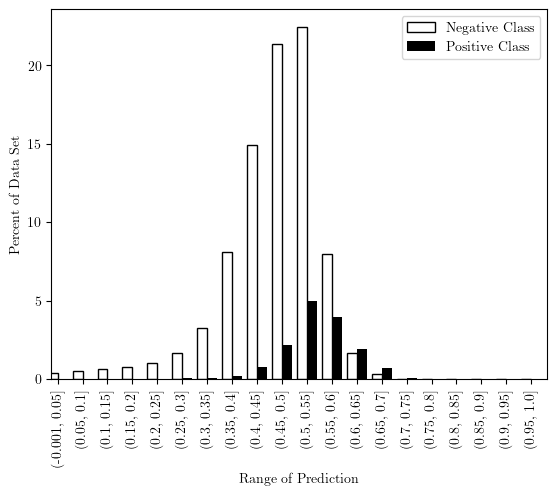

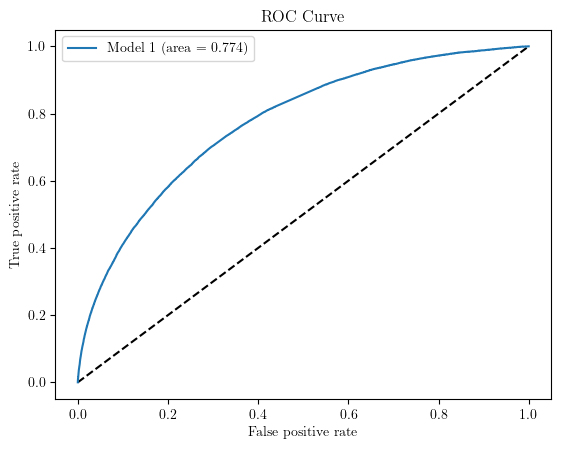



Tomek_Links()
X_train.shape before =  (413912, 174)
y_train.shape before =  (413912,)

X_train.shape after =  (399492, 174)
y_train.shape after =  (399492,)

Removed 14420 samples, or 3.48% of the set.

focal_loss, p = p, with Tomek once
Make_Model()
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               44800     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         

None


Train_Model()
5544/5544 [==============================] - 6s 1ms/step
Evaluate_Model()


array([[99865, 50906],
       [ 6958, 19663]])


tf.Tensor(26621.0, shape=(), dtype=float64) tf.Tensor(150771.0, shape=(), dtype=float64) tf.Tensor(19663.0, shape=(), dtype=float64) tf.Tensor(6958.0, shape=(), dtype=float64) tf.Tensor(99865.0, shape=(), dtype=float64) tf.Tensor(50906.0, shape=(), dtype=float64)
- Accuracy_Metric:  0.6738071615401632
- Balanced_Accuracy_Metric:  0.700494762380351
- Precision_Metric:  0.27863509472958575
- Balanced_Precision_Metric:  0.6862874954815481
- Recall_Metric:  0.7386273994187347
- F1_Metric:  0.40463022642440216
- Balanced_F1_Metric:  0.7114962741946474
- Gmean_Metric:  0.42960136584972447
Plot_Prediction()


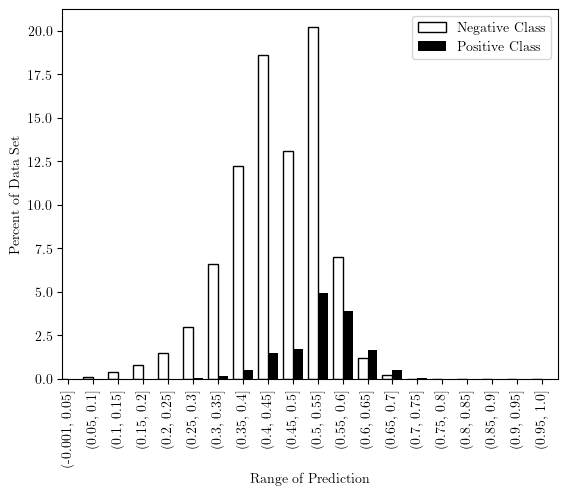

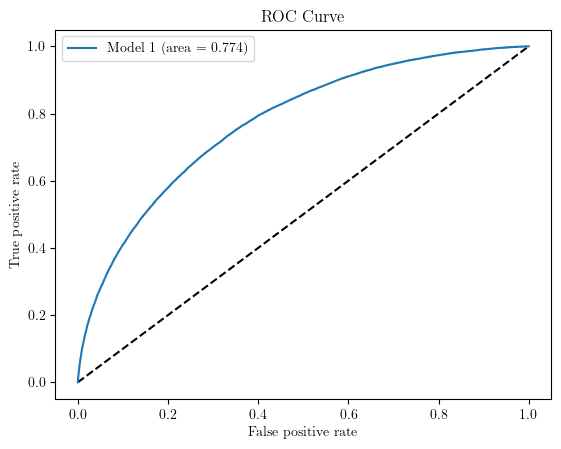



Tomek_Links()
X_train.shape before =  (399492, 174)
y_train.shape before =  (399492,)

X_train.shape after =  (396500, 174)
y_train.shape after =  (396500,)

Removed 2992 samples, or 0.75% of the set.

focal_loss, p = p, with Tomek twice
Make_Model()
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               44800     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         

None


Train_Model()
5544/5544 [==============================] - 7s 1ms/step
Evaluate_Model()


array([[98483, 52288],
       [ 6733, 19888]])


tf.Tensor(26621.0, shape=(), dtype=float64) tf.Tensor(150771.0, shape=(), dtype=float64) tf.Tensor(19888.0, shape=(), dtype=float64) tf.Tensor(6733.0, shape=(), dtype=float64) tf.Tensor(98483.0, shape=(), dtype=float64) tf.Tensor(52288.0, shape=(), dtype=float64)
- Accuracy_Metric:  0.6672848831961603
- Balanced_Accuracy_Metric:  0.7001376398991611
- Precision_Metric:  0.27554865883357965
- Balanced_Precision_Metric:  0.6829606589082757
- Recall_Metric:  0.7470793734241874
- F1_Metric:  0.40260343917473645
- Balanced_F1_Metric:  0.7135826707509835
- Gmean_Metric:  0.4242490494473468
Plot_Prediction()


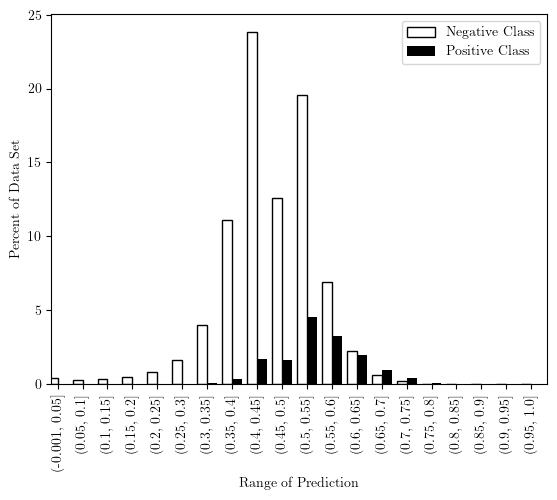

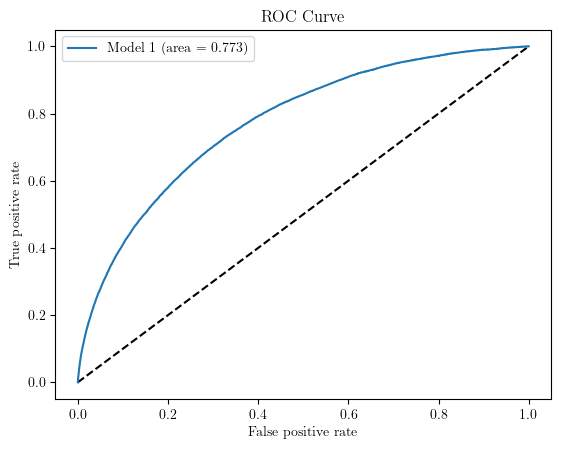



CPU times: user 2h 49min 50s, sys: 26min 50s, total: 3h 16min 40s
Wall time: 1h 42min 42s


In [38]:
%%time
def Main():
    target = 'HOSPITAL'

    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
    data = Thin_Features(data)
#    data = Really_Thin_Features(data)
    for feature in data:
        print (feature)
    print ()
    
    # Alternate dataset, for debugging
#    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
#    data = pd.read_csv(file_url)
#    target = 'target'

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.90)
#    data = X_train
#    data['HOSPITAL'] = y_train

    data = Get_Dummies(data, target)
    display(data.head())
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    print ('X_train.shape = ', X_train.shape)
    print ('X_test.shape = ', X_test.shape)
    print ('y_train.shape = ', y_train.shape)
    print ('y_test.shape = ', y_test.shape)
    print ()
    
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)
    
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    X_train.to_csv('../../Big_Files/X_train_after_Tomek.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_after_Tomek.csv', index=False)
#    X_train = pd.read_csv('../../Big_Files/X_train_after_Tomek.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_after_Tomek.csv')
    
    print (target)
    display (y_train)
    N = len(y_train)
    n = len(y_train[y_train==1])
#    n = len(y_train[y_train[target]=='1'])
    p = (N-n)/n
    print ('After Tomek:')
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
    
    print ('focal_loss, p = p, without Tomek Links')
    model = Make_Simple_Model(X_train)
    loss_function = focal_loss_with_parameters(p, 2.0, 2.0)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)

    X_train, y_train = Tomek_Links(X_train, y_train)
    print ('focal_loss, p = p, with Tomek once')
    model = Make_Simple_Model(X_train)
    loss_function = focal_loss_with_parameters(p, 2.0, 2.0)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)


    X_train, y_train = Tomek_Links(X_train, y_train)
    print ('focal_loss, p = p, with Tomek twice')
    model = Make_Simple_Model(X_train)
    loss_function = focal_loss_with_parameters(p, 2.0, 2.0)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)
    
    return model

    
    
    model = Make_Simple_Model(X_train)
#    p=100.0
    print ('alpha_weighted, p = p')
    loss_function = alpha_weighted_binary_crossentropy_with_parameters(p)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)
    print ('alpha_weighted, p = 1.0')
    loss_function = alpha_weighted_binary_crossentropy_with_parameters(1.0)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)
    print ('focal_loss, p = p')
    loss_function = focal_loss_with_parameters(p, 2.0, 2.0)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)
    print ('focal_loss, p = 1.0')
    loss_function = focal_loss_with_parameters(p, 2.0, 2.0)
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function)
    
    model = AdaBoost (X_train, X_test, y_train, y_test)
    model = Bagging (X_train, X_test, y_train, y_test)

    return model
        
model = Main()




### Tomek Links
Tomek_Links()

X_train.shape before =  (413912, 174)

y_train.shape before =  (413912,)

X_train.shape after =  (399492, 174)

y_train.shape after =  (399492,)

Removed 14420 samples, or 3.48% of the set.



### Focal loss without Tomek Links
    - val_loss: 0.0374 
    - val_fn: 6235.0000 
    - val_fp: 55525.0000 
    - val_tn: 95246.0000 
    - val_tp: 20386.0000 
    - val_precision: 0.2686 
    - val_recall: 0.7658 
    - val_accuracy: 0.6518 
    - val_Balanced_Accuracy_Metric: 0.6988 
    - val_Gmean_Metric: 0.4119 
    - val_Balanced_Precision_Metric: 0.6753 
    - val_F1_Metric: 0.3976 
    - val_Balanced_F1_Metric: 0.7176 
    
### Focal Loss with Tomek Links
- val_loss: 0.0381 
- val_fn: 9750.0000 
- val_fp: 35973.0000 
- val_tn: 114798.0000 
- val_tp: 16871.0000 
- val_precision: 0.3193 
- val_recall: 0.6337 
- val_accuracy: 0.7422 
- val_Balanced_Accuracy_Metric: 0.6976 
- val_Gmean_Metric: 0.4929 
- val_Balanced_Precision_Metric: 0.7263 
- val_F1_Metric: 0.4244 
- val_Balanced_F1_Metric: 0.6767

### Binary Crossentropy without Tomek Links
- val_loss: 0.1474 
- val_fn: 7103.0000 
- val_fp: 50101.0000 
- val_tn: 100670.0000 
- val_tp: 19518.0000 
- val_precision: 0.2804 
- val_recall: 0.7332 
- val_accuracy: 0.6775 
- val_Balanced_Accuracy_Metric: 0.7005 
- val_Gmean_Metric: 0.4327 
- val_Balanced_Precision_Metric: 0.6881 
- val_F1_Metric: 0.4055 
- val_Balanced_F1_Metric: 0.7098

### Binary Crossentropy with Tomek Links
- val_loss: 0.1459 
- val_fn: 6741.0000 
- val_fp: 52075.0000 
- val_tn: 98696.0000 
- val_tp: 19880.0000 
- val_precision: 0.2763 
- val_recall: 0.7468 
- val_accuracy: 0.6684 
- val_Balanced_Accuracy_Metric: 0.7007 
- val_Gmean_Metric: 0.4251 
- val_Balanced_Precision_Metric: 0.6836 
- val_F1_Metric: 0.4031 
- val_Balanced_F1_Metric: 0.7137 


### AdaBoost without Tomek Links

- TP =  2636.0  FN =  23985.0  FP =  2430.0  TN =  148341.0
- Accuracy_Metric:  0.8510924957152233
- Balanced_Accuracy_Metric:  0.5414512066027384
- Precision_Metric:  0.5203316225716477
- Balanced_Precision_Metric:  0.8600172336538433
- Recall_Metric:  0.09901957101499184
- F1_Metric:  0.16637752500834932
- Balanced_F1_Metric:  0.17759196575527375
- Gmean_Metric:  0.7155035679138011
    
### AdaBoost with Tomek Links

- TP =  3215.0  FN =  23406.0  FP =  3163.0  TN =  147608.0
- Accuracy_Metric:  0.8502243618647682
- Balanced_Accuracy_Metric:  0.5498952410012998
- Precision_Metric:  0.5040765130055805
- Balanced_Precision_Metric:  0.8519992322864999
- Recall_Metric:  0.12076931745568999
- F1_Metric:  0.19485452715697313
- Balanced_F1_Metric:  0.2115517445644662
- Gmean_Metric:  0.7024966724358691